In [6]:
!cd training && rm -r .ipynb_checkpoints
# !cd training && ls -a
#!rm -r saved_model


In [ ]:
# import opendatasets as od
import cv2
import tensorflow as tf
from tensorflow import keras
!pip3 install tensorflow_hub
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import os


In [7]:
# Defining variable
data_root = ("training/")
IMAGE_SHAPE = (224, 224) # (height, width) in no. of pixels
TRAINING_DATA_DIR = str(data_root)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

In [8]:
# Split the data into validation and training
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

Found 952 images belonging to 2 classes.
Found 3812 images belonging to 2 classes.


In [9]:
print (train_generator.class_indices)
print(train_generator.num_classes)

{'non-science': 0, 'science': 1}
2


In [10]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

non-science
science

In [11]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Non-Science' 'Science']


In [12]:
model = tf.keras.Sequential([
 hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 
 output_shape=[1280],
 trainable=False),
 tf.keras.layers.Dropout(0.4),
 tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [15]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=20,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/20
120/120 [==============================] - 121s 977ms/step - loss: 0.7835 - acc: 0.5997 - val_loss: 0.5595 - val_acc: 0.7153
Epoch 2/20
120/120 [==============================] - 111s 927ms/step - loss: 0.6393 - acc: 0.6734 - val_loss: 0.5621 - val_acc: 0.7174
Epoch 3/20
120/120 [==============================] - 112s 932ms/step - loss: 0.5946 - acc: 0.7009 - val_loss: 0.5643 - val_acc: 0.7195
Epoch 4/20
120/120 [==============================] - 110s 920ms/step - loss: 0.5729 - acc: 0.7120 - val_loss: 0.5468 - val_acc: 0.7216
Epoch 5/20
120/120 [==============================] - 111s 927ms/step - loss: 0.5730 - acc: 0.7162 - val_loss: 0.5396 - val_acc: 0.7384
Epoch 6/20
120/120 [==============================] - 110s 917ms/step - loss: 0.5440 - acc: 0.7298 - val_loss: 0.5453 - val_acc: 0.7342
Epoch 7/20
120/120 [==============================] - 112s 933ms/step - loss: 0.5570 - acc: 0.7198 - val_loss: 0.5671 - val_acc: 0.7059
Epoch 8/20
120/120 [============================

In [16]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


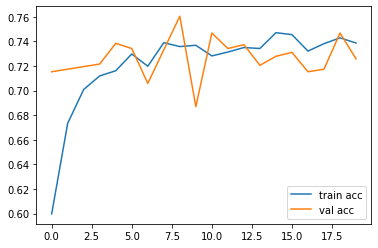

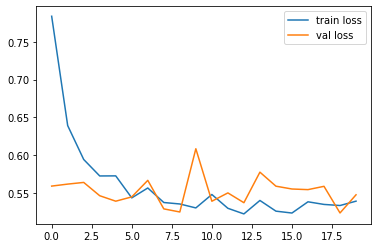

In [17]:
# accuracies
plt.plot(hist['acc'], label='train acc')
plt.plot(hist['val_acc'], label='val acc')
plt.legend()
plt.show()

# loss
plt.plot(hist['loss'], label='train loss')
plt.plot(hist['val_loss'], label='val loss')
plt.legend()
plt.show()

In [20]:
CLASS_NAMES = ['Non-Science', 'Science']

new_model = tf.keras.models.load_model('saved_model/my_model')
# print(new_model.summary())
test_path = "/content/testing"

for image in os.listdir(test_path):
    if(image == '.ipynb_checkpoints'):
        continue
    img = cv2.imread(test_path+"/"+image)
#     plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
#     # as opencv loads in BGR format by default, we want to show it in RGB.
#     plt.show()
    
    img = cv2.resize(img,(224,224))
    img = np.expand_dims(img,0)
    predict = new_model.predict(img)
    print(image)
#     print(predict)
    result = CLASS_NAMES[predict.argmax(axis=1)[0]]
    print(result)

crime_01.jpg
Science
non (1).jpg
Science
non (4).jpg
Science
crime_06.jpg
Science
crime_02.jpg
Science
crime_03.jpg
Non-Science
non (5).jpg
Non-Science
crime_05.jpg
Science
non (3).jpg
Science
crime_08.jpg
Science
crime_04.jpg
Science
non (2).jpg
Science
non (8).jpg
Science
crime_07.jpg
Non-Science
crime_09.jpg
Science
non (6).jpg
Science
non (7).jpg
Science
crime_10.jpg
Non-Science
engineering_01.jpg
Science
crime_11.jpg
Science
non (9).jpg
Science


In [21]:
CLASS_NAMES = ['Non-science', 'Science']
result = CLASS_NAMES[predict.argmax(axis=1)[0]]
print(result)

Science
